In [1]:
import numpy as py
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import pandas_gbq as gbq
import scipy.stats

from math import sqrt
from py4j.protocol import Py4JJavaError
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from google.cloud import bigquery
from google.oauth2 import service_account
from pyspark.sql import SparkSession
from sklearn.model_selection import GroupKFold
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
from scipy.stats import zscore

In [2]:
credentials = service_account.Credentials.from_service_account_file('/home/primukh26/demand-forecasting-exploratory-f32357b1b4ed.json')
project_id = 'demand-forecasting-exploratory'
client = bigquery.Client(credentials= credentials,project=project_id)
PROJECT = "demand-forecasting-exploratory"
DATASET = 'Demand_Forecasting'
TABLE = 'master_traindata'
BUCKET = "demandforecasting"

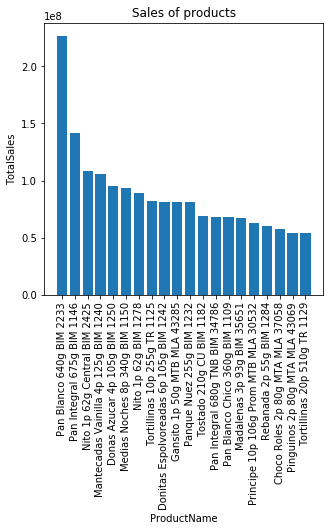

In [95]:
#Show top100 products
query_job = client.query("""
 select ProductName, sum(SalesDollarThisWeek)
from Demand_Forecasting.master_traindata
group by ProductName
order by sum(SalesDollarThisWeek) desc
limit 20""")
results = query_job.result()
df = query_job.to_dataframe()
plt.bar(df["ProductName"], df["f0_"])
plt.xlabel('ProductName', fontsize=10)
plt.ylabel('TotalSales', fontsize=10)
plt.xticks(df["ProductName"], fontsize=10, rotation='vertical')
plt.title('Sales of products')
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

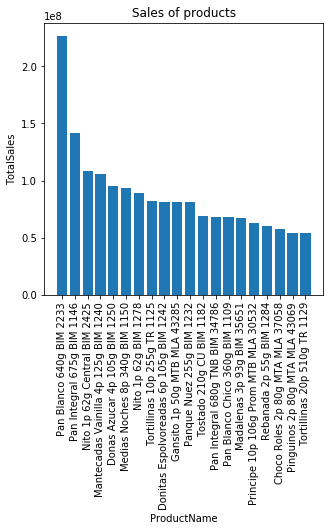

In [96]:
#Show lowest selling products
query_job = client.query("""
 select ProductName, sum(SalesDollarThisWeek)
from Demand_Forecasting.master_traindata where SalesDollarThisWeek>0
group by ProductName
order by sum(SalesDollarThisWeek)desc 
limit 20""")
results = query_job.result()
df = query_job.to_dataframe()
plt.bar(df["ProductName"], df["f0_"])
plt.xlabel('ProductName', fontsize=10)
plt.ylabel('TotalSales', fontsize=10)
plt.xticks(df["ProductName"], fontsize=10, rotation='vertical')
plt.title('Sales of products')
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

Text(0, 0.5, 'Total Sales')

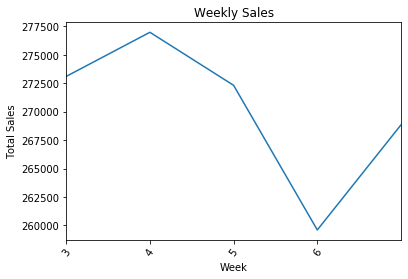

In [5]:
# By Week
query_job = client.query("""
 select WeekNumber, ClientID, ProductID,Demand, SalesUnitThisWeek,ReturnsUnitNextWeek
from Demand_Forecasting.master_traindata where SalesDollarThisWeek > 300 and WeekNumber <8
order by WeekNumber
""")
results = query_job.result()
df = query_job.to_dataframe()
sales_by_week = df.groupby('WeekNumber').size()
plot_by_week = sales_by_week.plot(title='Weekly Sales',xticks=(range(3,7)),rot=55)
plot_by_week.set_xlabel('Week')
plot_by_week.set_ylabel('Total Sales')

Enter ProductID : 36442


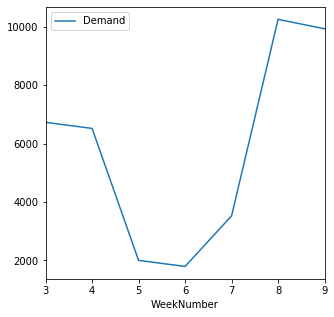

In [90]:
#plot timeseries for one product (highest selling)
pid = input("Enter ProductID : ")
pid_int = int(pid)
query ="""
select WeekNumber ,sum(Demand) As Demand
from Demand_Forecasting.master_traindata where ProductID=@pid_int
group by WeekNumber
order by WeekNumber
""" 

query_params = [
    bigquery.ScalarQueryParameter("pid_int", "INT64", pid_int),
]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query,location="US",
    job_config=job_config,
)
results = query_job.result()
df_prod_plot = query_job.to_dataframe()
index_week = df_prod_plot["WeekNumber"]
#print(index_week)
df_prod_plot_by_week = df_prod_plot.groupby(index_week).mean()
df_prod_plot_by_week.plot()
plt.rcParams["figure.figsize"] = [5,5]
plt.show()

In [4]:
#Feature Engineering --- Include price of each item
query_job = client.query("""
select ProductID, UnitPrice from Demand_Forecasting.PriceTable
""")
results = query_job.result()
unitprice = query_job.to_dataframe()
unitprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719 entries, 0 to 1718
Data columns (total 2 columns):
ProductID    1719 non-null int64
UnitPrice    1719 non-null float64
dtypes: float64(1), int64(1)
memory usage: 27.0 KB


In [4]:
#Get training data ---- because of lack of resources, only those products are being taken which usually have Sales>300 pesos
query_job = client.query("""
 select WeekNumber ,SalesChannelID, RouteID,SalesDepotID, ClientID, ProductID,Demand, SalesUnitThisWeek,ReturnsUnitNextWeek
from Demand_Forecasting.master_traindata where SalesDollarThisWeek > 300 and WeekNumber <8
order by WeekNumber
""")
results = query_job.result()
df_train = query_job.to_dataframe()
df_train.info()
df_train = df_train.merge(unitprice,how='left',on='ProductID')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350852 entries, 0 to 1350851
Data columns (total 9 columns):
WeekNumber             1350852 non-null int64
SalesChannelID         1350852 non-null int64
RouteID                1350852 non-null int64
SalesDepotID           1350852 non-null int64
ClientID               1350852 non-null int64
ProductID              1350852 non-null int64
Demand                 1350852 non-null int64
SalesUnitThisWeek      1350852 non-null int64
ReturnsUnitNextWeek    1350852 non-null int64
dtypes: int64(9)
memory usage: 92.8 MB


In [5]:
df_train.head()

,WeekNumber,SalesChannelID,RouteID,SalesDepotID,ClientID,ProductID,Demand,SalesUnitThisWeek,ReturnsUnitNextWeek,UnitPrice
0,3,11,3905,1465,80839,31310,49,49,0,6.088720
1,3,2,57,1114,19189,31467,48,48,0,10.340089
2,3,5,3001,1673,653378,30548,88,96,8,6.153164
3,3,2,7231,2061,2387260,34794,42,42,0,21.016761
4,3,7,3302,1279,60567,47336,45,45,0,12.425412


count    1.350852e+06
mean     7.319151e+01
std      1.111431e+02
min      0.000000e+00
25%      2.500000e+01
50%      4.400000e+01
75%      8.000000e+01
max      5.000000e+03
Name: Demand, dtype: float64


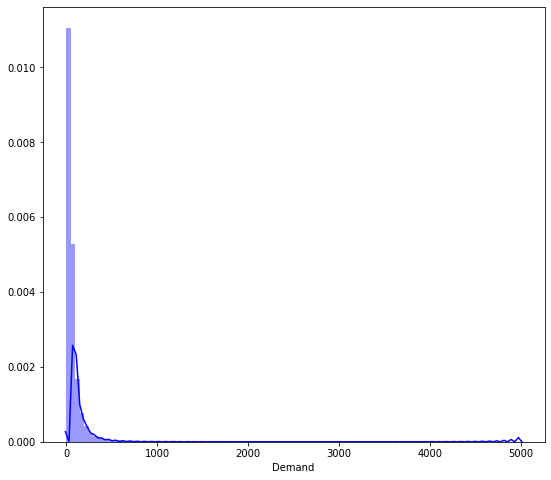

In [6]:
# Demand Distribution
print(df_train['Demand'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df_train['Demand'], color='b', bins=100, hist_kws={'alpha': 0.4});


In [7]:
# Correlations
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()['Demand'][:-1]
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There are {} strongly correlated values with Demand:\n{}".format(len(golden_features_list), golden_features_list))

There are 2 strongly correlated values with Demand:
Demand               1.000000
SalesUnitThisWeek    0.997637
Name: Demand, dtype: float64


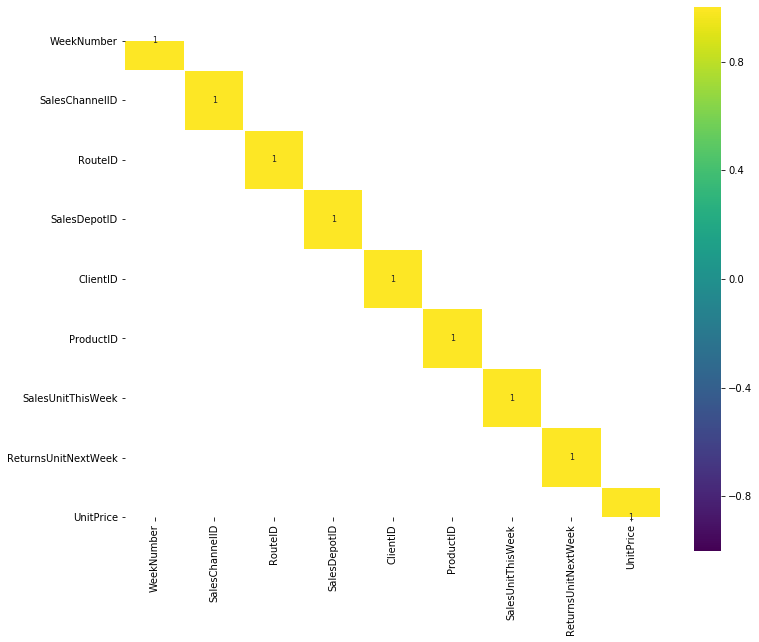

In [8]:
# Heatmap
corr = df_num.drop('Demand', axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [31]:
#Since RouteId and SalesChannelId are correlated, we will only keep one of them for model building
query_job = client.query("""
 select WeekNumber , SalesDepotId, SalesChannelId, ClientID, ProductID, Demand, SalesUnitThisWeek
from Demand_Forecasting.master_traindata where Demand > 20 and WeekNumber <8
order by WeekNumber
""")
results = query_job.result()
df_train = query_job.to_dataframe()
df_train.info()
df_train = df_train.merge(unitprice,how='left',on='ProductID')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075936 entries, 0 to 3075935
Data columns (total 7 columns):
WeekNumber           int64
SalesDepotId         int64
SalesChannelId       int64
ClientID             int64
ProductID            int64
Demand               int64
SalesUnitThisWeek    int64
dtypes: int64(7)
memory usage: 164.3 MB


In [32]:
#Get test data ---- because of lack of resources, only those products are being taken which usually have Sales>300 pesos
query_job = client.query("""
 select WeekNumber , SalesDepotId,SalesChannelId, ClientID, ProductID, Demand, SalesUnitThisWeek
from Demand_Forecasting.master_traindata where Demand > 20 and WeekNumber =8
order by WeekNumber
""")
results = query_job.result()
df_test = query_job.to_dataframe()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612522 entries, 0 to 612521
Data columns (total 7 columns):
WeekNumber           612522 non-null int64
SalesDepotId         612522 non-null int64
SalesChannelId       612522 non-null int64
ClientID             612522 non-null int64
ProductID            612522 non-null int64
Demand               612522 non-null int64
SalesUnitThisWeek    612522 non-null int64
dtypes: int64(7)
memory usage: 32.7 MB


In [33]:
df_test = df_test.merge(unitprice,how='left',on='ProductID')
df_test.head()

,WeekNumber,SalesDepotId,SalesChannelId,ClientID,ProductID,Demand,SalesUnitThisWeek,UnitPrice
0,8,4013,4,120671,37058,26,26,7.542543
1,8,1477,4,1176400,37058,34,34,7.542543
2,8,1493,4,2059395,37058,35,35,7.542543
3,8,2211,1,4211360,37058,24,24,7.542543
4,8,1123,1,646862,1278,35,35,4.498788


In [34]:
df_train.head()

,WeekNumber,SalesDepotId,SalesChannelId,ClientID,ProductID,Demand,SalesUnitThisWeek,UnitPrice
0,3,1216,1,922779,37058,23,23,7.542543
1,3,1221,1,63226,37058,37,37,7.542543
2,3,1310,1,100757,37058,22,22,7.542543
3,3,1111,1,2205287,37058,34,34,7.542543
4,3,23669,1,250080,37058,25,25,7.542543


In [35]:
df_train.isnull().sum()

WeekNumber           0
SalesDepotId         0
SalesChannelId       0
ClientID             0
ProductID            0
Demand               0
SalesUnitThisWeek    0
UnitPrice            0
dtype: int64

In [36]:
df_train.head()

,WeekNumber,SalesDepotId,SalesChannelId,ClientID,ProductID,Demand,SalesUnitThisWeek,UnitPrice
0,3,1216,1,922779,37058,23,23,7.542543
1,3,1221,1,63226,37058,37,37,7.542543
2,3,1310,1,100757,37058,22,22,7.542543
3,3,1111,1,2205287,37058,34,34,7.542543
4,3,23669,1,250080,37058,25,25,7.542543


In [37]:
df_test.head()

,WeekNumber,SalesDepotId,SalesChannelId,ClientID,ProductID,Demand,SalesUnitThisWeek,UnitPrice
0,8,4013,4,120671,37058,26,26,7.542543
1,8,1477,4,1176400,37058,34,34,7.542543
2,8,1493,4,2059395,37058,35,35,7.542543
3,8,2211,1,4211360,37058,24,24,7.542543
4,8,1123,1,646862,1278,35,35,4.498788


In [38]:
df_train.isna().sum()

WeekNumber           0
SalesDepotId         0
SalesChannelId       0
ClientID             0
ProductID            0
Demand               0
SalesUnitThisWeek    0
UnitPrice            0
dtype: int64

In [39]:
#remove duplicates
#len(df_train[df_train.duplicated()])
col=['WeekNumber' , 'ClientID', 'ProductID', 'SalesDepotId']
print(df_train.duplicated(subset=col).value_counts())
df_train.drop_duplicates(subset=col, inplace=True)

False    2954427
True      121509
dtype: int64


In [40]:
#remove duplicates
#len(df_train[df_train.duplicated()])
col=['WeekNumber' , 'ClientID', 'ProductID', 'SalesDepotId']
print(df_test.duplicated(subset=col).value_counts())
df_test.drop_duplicates(subset=col, inplace=True)

False    588836
True      23686
dtype: int64


In [41]:
#check if all duplicates have been removed
len(df_train[df_train.duplicated()])

0

In [42]:
len(df_test[df_test.duplicated()])

0

In [43]:
#Run summary statistics 
print(df_train['Demand'].describe())

count    2.954427e+06
mean     5.013069e+01
std      7.081058e+01
min      2.100000e+01
25%      2.600000e+01
50%      3.500000e+01
75%      4.800000e+01
max      5.000000e+03
Name: Demand, dtype: float64


In [44]:
print("Total number of weeks:", (df_train['WeekNumber'].max()-df_train['WeekNumber'].min())+1)

Total number of weeks: 5


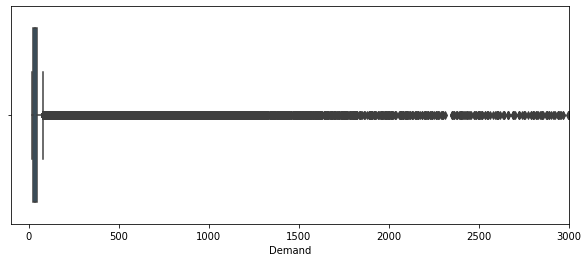

In [45]:
#Check for outliers
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=df_train['Demand'])

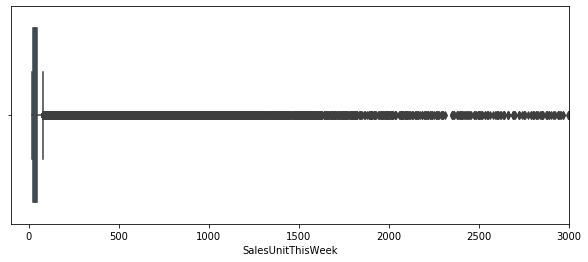

In [46]:
#Check for outliers
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=df_train['SalesUnitThisWeek'])


In [47]:
#Using z-score to remove outliers
df_train = df_train[(py.abs(scipy.stats.zscore(df_train.drop(['WeekNumber' , 'ClientID', 'ProductID', 'SalesDepotId'], axis=1))) < 3).all(axis=1)]

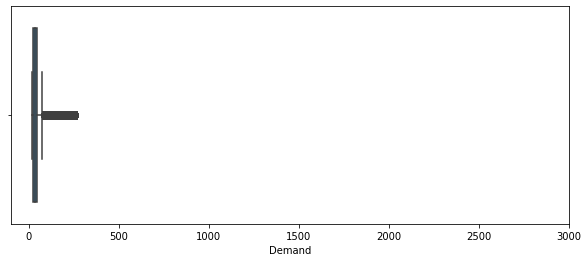

In [48]:
#Plot the distribution once again
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=df_train['Demand'])

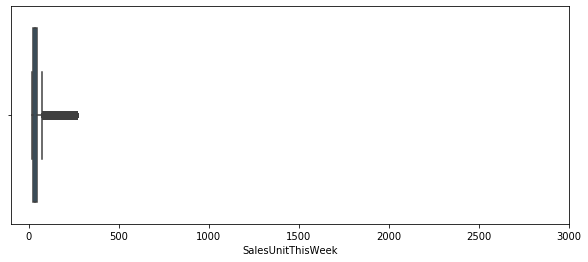

In [49]:
#Plot the distribution once again
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=df_train['SalesUnitThisWeek'])

In [45]:
#Load Test Data
#query_job = client.query("""
#select Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
#from Demand_Forecasting.test_data
#order by Semana
#""")
#results = query_job.result()
#df_test = query_job.to_dataframe()

In [46]:
#print("Total number of items in test:",len(list(set(df_test.Semana))))
#df_test=df_test.rename(columns = {"Semana": "WeekNumber", 
#                     "Agencia_ID":"SalesDepotID","Canal_ID": "SalesChannelID", 
#                     "Ruta_SAK":"RouteID",  "Cliente_ID":"ClientID", "Producto_ID":"ProductID"})
#df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999251 entries, 0 to 6999250
Data columns (total 6 columns):
WeekNumber        int64
SalesDepotID      int64
SalesChannelID    int64
RouteID           int64
ClientID          int64
ProductID         int64
dtypes: int64(6)
memory usage: 320.4 MB


In [50]:
print("new items in test(in test but not in train):",len(list(set(df_test.ProductID) - set(df_test.ProductID).intersection(set(df_train.ProductID)))))

new items in test(in test but not in train): 198


In [52]:
test_products = df_test.ProductID.unique()
test_clients = df_test.ClientID.unique()
test_salesdepot = df_test.SalesDepotId.unique()
test_saleschannel = df_test.SalesChannelId.unique()


df_train = df_train[df_train.ProductID.isin(test_products)]
df_train = df_train[df_train.ClientID.isin(test_clients)]
df_train = df_train[df_train.SalesDepotId.isin(test_salesdepot)]
df_train = df_train[df_train.SalesChannelId.isin(test_saleschannel)]


#print("Total number of items in test:",len(list(set(df_test.id))))

In [53]:
#df_testing=df_test.drop('Demand',axis=1)
df_test.head()


,WeekNumber,SalesDepotId,SalesChannelId,ClientID,ProductID,Demand,SalesUnitThisWeek,UnitPrice
0,8,4013,4,120671,37058,26,26,7.542543
1,8,1477,4,1176400,37058,34,34,7.542543
2,8,1493,4,2059395,37058,35,35,7.542543
3,8,2211,1,4211360,37058,24,24,7.542543
4,8,1123,1,646862,1278,35,35,4.498788


In [54]:
#Separate x variables and y variables
x_test = df_test.drop(['Demand'], axis=1)
y_test = df_test['Demand']
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588836 entries, 0 to 612521
Data columns (total 7 columns):
WeekNumber           588836 non-null int64
SalesDepotId         588836 non-null int64
SalesChannelId       588836 non-null int64
ClientID             588836 non-null int64
ProductID            588836 non-null int64
SalesUnitThisWeek    588836 non-null int64
UnitPrice            588836 non-null float64
dtypes: float64(1), int64(6)
memory usage: 35.9 MB


In [55]:
#Separate x variables and y variables
x_train = df_train.drop(['Demand'], axis=1)
y_train = df_train['Demand']
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345323 entries, 0 to 3075935
Data columns (total 7 columns):
WeekNumber           int64
SalesDepotId         int64
SalesChannelId       int64
ClientID             int64
ProductID            int64
SalesUnitThisWeek    int64
UnitPrice            float64
dtypes: float64(1), int64(6)
memory usage: 143.1 MB


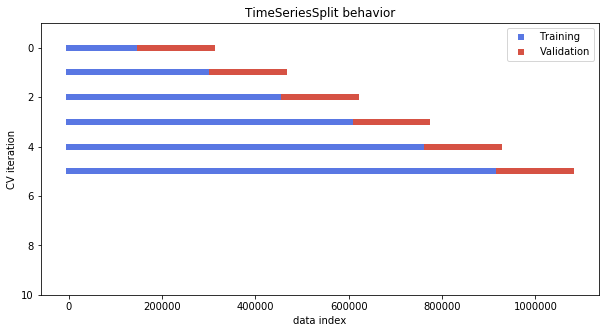

In [106]:
# Plot training and test indices walk forward
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=6)
fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr, tt) in enumerate(cv.split(x_train, y_train)):
# Plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)],
    marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)],
    marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior',
    xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

XGBoost Model

In [56]:
#XGBoost
# Create KFold cross-validation object
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
cv = TimeSeriesSplit(n_splits=6)
mean_y = df_train.mean(axis = 0)
# Iterate through CV splits  
oof_preds = py.zeros(x_train.shape[0])
sub_preds = py.zeros(x_test.shape[0])
results = []
gbm_param_grid = {'learning_rate': [0.01,0.1,0.5,0.9],
'n_estimators': [3000],
'subsample': [0.3, 0.5,0.9]}
feat_label = ['WeekNumber','SalesDepotId','SalesChannelId','ClientID','ProductID','SalesUnitThisWeek','UnitPrice']
error = []
for ii,(tr, tt) in enumerate(cv.split(x_train, y_train)):
    # Fit the model on training data
    trn_x, trn_y = x_train.iloc[tr], y_train[tr]
    val_x, val_y = x_train.iloc[tt], y_train[tt]
    trn_y=py.nan_to_num(trn_y)
    val_y=py.nan_to_num(val_y)
    #model = xgb.XGBRegressor()
    eval_s = [(x_train, y_train),(val_x, val_y)]
    model = xgb.XGBRegressor(n_jobs=-1, objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
               max_depth = 10, alpha = 10, n_estimators = 3000,subsample=0.9)
    #grid_mse = GridSearchCV(estimator=model,param_grid=gbm_param_grid,scoring='neg_mean_squared_error', cv=4, verbose=4,n_jobs=-1)
    model.fit(trn_x, trn_y,eval_set=eval_s,early_stopping_rounds=50, verbose=500)
   # print("Eval Result: ",model.evals_result())
    feature_importance_xgb = (feat_label,model.feature_importances_)
    indices = py.argsort(feature_importance_xgb[1])
    print("Indices",indices)
    oof_preds = model.predict(val_x)
    results.append((oof_preds))
    error.append(sqrt(metrics.mean_squared_error(val_y,oof_preds)))
    sub_preds+=model.predict(x_test)/cv.n_splits
    #print("Best parameters found: ",grid_mse.best_params_)
    #print("Lowest RMSE found: ", py.sqrt(py.abs(model.best_score_)))



/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:24:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.4029	validation_1-rmse:46.0607
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[32]	validation_0-rmse:35.2344	validation_1-rmse:34.6616

Indices [0 2 4 5 6 1 3]


/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:24:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.4255	validation_1-rmse:46.3413
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[44]	validation_0-rmse:35.1937	validation_1-rmse:34.7042

Indices [0 2 4 6 5 1 3]


/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:25:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.428	validation_1-rmse:46.9173
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[48]	validation_0-rmse:35.1809	validation_1-rmse:35.2324

Indices [2 0 4 1 6 5 3]


/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:25:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.4248	validation_1-rmse:46.5644
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[49]	validation_0-rmse:35.0957	validation_1-rmse:34.7792

Indices [2 0 4 1 6 5 3]


/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.4231	validation_1-rmse:46.9682
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[53]	validation_0-rmse:35.0545	validation_1-rmse:35.1751

Indices [2 0 4 6 1 5 3]


/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.4201	validation_1-rmse:46.5066
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[34]	validation_0-rmse:35.2533	validation_1-rmse:34.9572

Indices [2 6 0 4 5 1 3]


In [57]:
error
errors_=pd.DataFrame(error).head()

In [58]:
print("Training RMSE: ", errors_[0].mean())

Training RMSE:  34.91062867755659


In [59]:
pr=pd.DataFrame(sub_preds)
pr.index = x_test.index
pr.columns = ["Prediction"]
predDf = x_test.merge(pr, left_index=True, right_index=True)
predDfcomp = predDf.merge(y_test,left_index=True, right_index=True)
predDfcomp['Error'] = predDfcomp.apply(lambda row: (row['Demand'] -row['Prediction'])**2, axis=1)
predDfcomp.to_csv("prediction_results_xgboost.csv")
predDfcomp.head()

,WeekNumber,SalesDepotId,SalesChannelId,ClientID,ProductID,SalesUnitThisWeek,UnitPrice,Prediction,Demand,Error
0,8,4013,4,120671,37058,26,7.542543,34.002557,26,64.040915
1,8,1477,4,1176400,37058,34,7.542543,34.226522,34,0.051312
2,8,1493,4,2059395,37058,35,7.542543,34.379550,35,0.384958
3,8,2211,1,4211360,37058,24,7.542543,34.226457,24,104.580425
4,8,1123,1,646862,1278,35,4.498788,34.233061,35,0.588195


In [60]:
error_test = sqrt(metrics.mean_squared_error(y_test,pr))

In [61]:
print("Test RMSE: ", error_test)

Test RMSE:  71.75334490285891


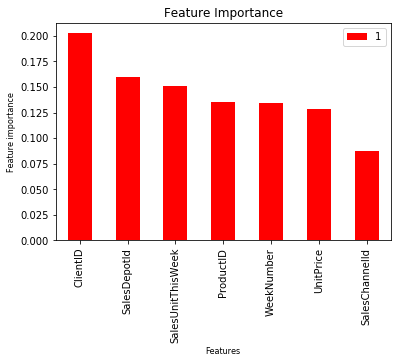

In [62]:
import pandas as pd
imp=pd.DataFrame(list(feature_importance_xgb))
imp=imp.transpose()
imp = imp.sort_values(by=[1], ascending=False)
#imp.head()
imp.plot(kind='bar',x=0,y=1,color='red')
plt.xlabel('Features', fontsize=8)
plt.ylabel('Feature importance', fontsize=8)
plt.title('Feature Importance')
plt.show()

Random Forest Regressor Model

In [71]:
#RandomForestRegressor
# Create KFold cross-validation object
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
cv = TimeSeriesSplit(n_splits=6)
mean_y = df_train.mean(axis = 0)
# Iterate through CV splits  
#oof_preds = py.zeros(x_train.shape[0])
sub_preds = py.zeros(x_test.shape[0])
results = []
random_grid = {'n_estimators': [200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 20, 30, 40, 50],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
feat_label = ['WeekNumber','ClientID','SalesChannelId','ProductID','SalesDepotId','SalesUnitThisWeek','UnitPrice']

error=[]
for ii,(tr, tt) in enumerate(cv.split(x_train, y_train)):
    # Fit the model on training data
    trn_x, trn_y = x_train.iloc[tr], y_train[tr]
    val_x, val_y = x_train.iloc[tt], y_train[tt]
    trn_y=py.nan_to_num(trn_y)
    val_y=py.nan_to_num(val_y)
    #rf = RandomForestRegressor()
    modelrf = RandomForestRegressor(n_jobs=-1,n_estimators=100, max_features='sqrt',
                              random_state=42, criterion='mse',oob_score=True,bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2)
    #grid_mserf = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 4, verbose=4, n_jobs = -1)
   
    modelrf.fit(trn_x, trn_y)
    feature_importance_rf = (feat_label,modelrf.feature_importances_)
    std = py.std([tree.feature_importances_ for tree in modelrf.estimators_],
             axis=0)
    indices = py.argsort(feature_importance_rf[1])
    preds = modelrf.predict(val_x)
    results.append((preds))
    error.append(sqrt(metrics.mean_squared_error(val_y,preds)))
    sub_preds+=modelrf.predict(x_test)/cv.n_splits
    #print("Best parameters found: ",grid_mserf.best_params_)
    #print("Lowest RMSE found: ", py.sqrt(py.abs(modelrf.best_score_)))



/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative

In [72]:
errors_=pd.DataFrame(error).head()

In [73]:
print("Training RMSE: ", errors_[0].mean())

Training RMSE:  34.90365633826895


In [66]:
pt = pd.DataFrame(results)
pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Columns: 335046 entries, 0 to 335045
dtypes: float64(335046)
memory usage: 15.3 MB


In [74]:
prrf=pd.DataFrame(sub_preds)
prrf.index = x_test.index
prrf.columns = ["Prediction"]
predDfrf = x_test.merge(prrf, left_index=True, right_index=True)
predDfrfcomp = predDfrf.merge(y_test,left_index=True, right_index=True)
predDfrfcomp['Error'] = predDfrfcomp.apply(lambda row: row['Demand'] -row['Prediction'], axis=1)
predDfrfcomp.to_csv("prediction_results_randomforest.csv")
predDfrfcomp.head()

,WeekNumber,SalesDepotId,SalesChannelId,ClientID,ProductID,SalesUnitThisWeek,UnitPrice,Prediction,Demand,Error
0,8,4013,4,120671,37058,26,7.542543,34.898619,26,-8.898619
1,8,1477,4,1176400,37058,34,7.542543,34.806549,34,-0.806549
2,8,1493,4,2059395,37058,35,7.542543,34.785264,35,0.214736
3,8,2211,1,4211360,37058,24,7.542543,34.687511,24,-10.687511
4,8,1123,1,646862,1278,35,4.498788,34.825672,35,0.174328


In [75]:
error_test = sqrt(metrics.mean_squared_error(y_test,prrf))

In [76]:
print("Test RMSE: " ,error_test)

Test RMSE:  71.47054365501327


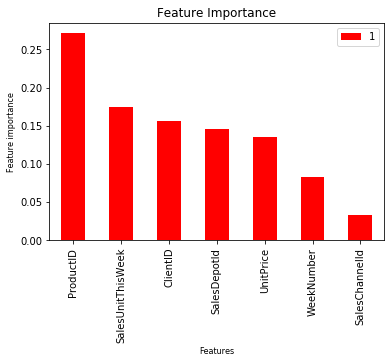

In [77]:
import pandas as pd
imp=pd.DataFrame(list(feature_importance_rf))
imp=imp.transpose()
imp = imp.sort_values(by=[1], ascending=False)
#imp.head()
imp.plot(kind='bar',x=0,y=1,color='red')
plt.xlabel('Features', fontsize=8)
plt.ylabel('Feature importance', fontsize=8)
plt.title('Feature Importance')
plt.show()

In [78]:
#LightGBM
# Create KFold cross-validation object
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble, metrics
from sklearn import linear_model, preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
cv = TimeSeriesSplit(n_splits=6)
mean_y = df_train.mean(axis = 0)
# Iterate through CV splits  
oof_preds = py.zeros(x_train.shape[0])
sub_preds = py.zeros(x_test.shape[0])
results = []
lgbm_param_grid = {'learning_rate': 0.05,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 50,
        'verbose': 1,
        'random_state':123,
        'bagging_fraction': 1,
        'feature_fraction': 1
       }
feat_label = ['WeekNumber','ClientID','ProductID','SalesUnitThisWeek','ReturnsUnitNextWeek','UnitPrice']
error = []
for ii,(tr, tt) in enumerate(cv.split(x_train, y_train)):
    # Fit the model on training data
    trn_x, trn_y = x_train.iloc[tr], y_train[tr]
    val_x, val_y = x_train.iloc[tt], y_train[tt]
    trn_y=py.nan_to_num(trn_y)
    val_y=py.nan_to_num(val_y)
    #model = xgb.XGBRegressor()
    eval_s = [(x_train, y_train),(val_x, val_y)]
    modellgb = lgb.LGBMRegressor(**lgbm_param_grid,n_jobs=-1,n_estimators = 200)
    #grid_mse = GridSearchCV(estimator=model,param_grid=gbm_param_grid,scoring='neg_mean_squared_error', cv=4, verbose=4,n_jobs=-1)
    model.fit(trn_x, trn_y,eval_set=eval_s,early_stopping_rounds=50, verbose=500)
   # print("Eval Result: ",model.evals_result())
    #feature_importance_lgb = (feat_label,modellgb.feature_importances_)
    #indices = py.argsort(feature_importance_lgb[1])
    #print("Indices",indices)
    oof_preds[tt] = model.predict(val_x)
    #results.append((oof_preds))
    #error.append(sqrt(metrics.mean_squared_error(val_y,oof_preds)))
    sub_preds+=model.predict(x_test)/cv.n_splits
    #print("Best parameters found: ",grid_mse.best_params_)
    #print("Lowest RMSE found: ", py.sqrt(py.abs(grid_mse.best_score_)))

/home/primukh26/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/primukh26/miniconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.4029	validation_1-rmse:46.0607
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[32]	validation_0-rmse:35.2344	validation_1-rmse:34.6616

[19:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:53.4255	validation_1-rmse:46.3413
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[44]	validation_0-rmse:35.1937	validation_1-rmse:34.7042

[19:45:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse

In [79]:
prlgb=pd.DataFrame(sub_preds)
prlgb.index = x_test.index
prlgb.columns = ["Prediction"]
predDflgb = x_test.merge(prlgb, left_index=True, right_index=True)
predDflgbcomp = predDflgb.merge(y_test,left_index=True, right_index=True)
predDflgbcomp['Error'] = predDflgbcomp.apply(lambda row: row['Demand'] -row['Prediction'], axis=1)
predDflgbcomp.to_csv("prediction_results_randomlgb.csv")
predDflgbcomp.head()

,WeekNumber,SalesDepotId,SalesChannelId,ClientID,ProductID,SalesUnitThisWeek,UnitPrice,Prediction,Demand,Error
0,8,4013,4,120671,37058,26,7.542543,34.002557,26,-8.002557
1,8,1477,4,1176400,37058,34,7.542543,34.226522,34,-0.226522
2,8,1493,4,2059395,37058,35,7.542543,34.379550,35,0.620450
3,8,2211,1,4211360,37058,24,7.542543,34.226457,24,-10.226457
4,8,1123,1,646862,1278,35,4.498788,34.233061,35,0.766939


In [80]:
error_test = sqrt(metrics.mean_squared_error(y_test,prlgb))

In [81]:
print("Test MSE:",error_test)

Test MSE: 71.75334490285891


In [104]:
df_train["Year"]=2019

In [105]:
df_train.head()

,WeekNumber,SalesDepotID,SalesChannelID,RouteID,ClientID,ProductID,Demand,SalesUnitThisWeek,ReturnsUnitNextWeek,UnitPrice,Year
0,3,1978,5,3001,653378,37058,167,167,0,7.542543,2019
1,3,1473,4,4704,4710407,37058,72,72,0,7.542543,2019
2,3,1629,1,2022,4131832,37058,50,50,0,7.542543,2019
3,3,4063,2,1553,2497363,37058,72,72,0,7.542543,2019
4,3,1620,1,1124,1552329,1278,80,80,0,4.498788,2019


In [106]:
df_train["ds"] = pd.to_datetime(df_train.WeekNumber.astype(str)+
                          df_train.Year.astype(str).add('-0') ,format='%W%Y-%w')
df_train.tail()

,WeekNumber,SalesDepotID,SalesChannelID,RouteID,ClientID,ProductID,Demand,SalesUnitThisWeek,ReturnsUnitNextWeek,UnitPrice,Year,ds
1350847,7,2265,7,3307,4414498,4280,73,73,0,6.538163,2019,2019-02-24
1350848,7,1616,1,1042,691727,2233,17,17,0,19.902817,2019,2019-02-24
1350849,7,1124,1,1015,184201,1160,19,19,0,18.893224,2019,2019-02-24
1350850,7,1118,1,1039,73266,1160,21,21,0,18.893224,2019,2019-02-24
1350851,7,4081,5,3005,653378,37058,70,72,2,7.542543,2019,2019-02-24


In [108]:
df_train1=df_train.rename(columns={'Demand': 'y'})
df_train1.head()

,WeekNumber,SalesDepotID,SalesChannelID,RouteID,ClientID,ProductID,y,SalesUnitThisWeek,ReturnsUnitNextWeek,UnitPrice,Year,ds
0,3,1978,5,3001,653378,37058,167,167,0,7.542543,2019,2019-01-27
1,3,1473,4,4704,4710407,37058,72,72,0,7.542543,2019,2019-01-27
2,3,1629,1,2022,4131832,37058,50,50,0,7.542543,2019,2019-01-27
3,3,4063,2,1553,2497363,37058,72,72,0,7.542543,2019,2019-01-27
4,3,1620,1,1124,1552329,1278,80,80,0,4.498788,2019,2019-01-27


In [111]:
ts=df_train1.groupby(["ds"])["y"].sum()

In [112]:
ts.head()

ds
2019-01-27    14966183
2019-02-03    15413777
2019-02-10    15182179
2019-02-17    14654067
2019-02-24    15246451
Name: y, dtype: int64

In [118]:
ts=ts.reset_index()

ts.tail()


,ds,y
0,2019-01-27,14966183
1,2019-02-03,15413777
2,2019-02-10,15182179
3,2019-02-17,14654067
4,2019-02-24,15246451


In [121]:
from fbprophet import Prophet
import matplotlib.pyplot as plt
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( weekly_seasonality=True) #instantiate Prophet with weekly seasonality
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


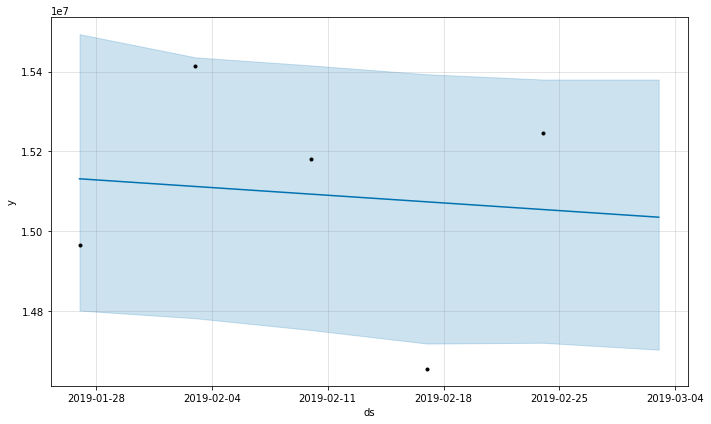

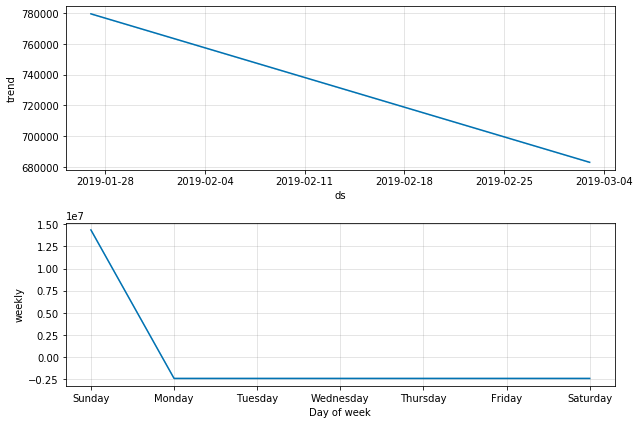

          ds          trend    yhat_lower    yhat_upper    trend_lower  \
0 2019-01-27  779461.931219  1.480084e+07  1.549409e+07  779461.931219   
1 2019-02-03  760201.773877  1.478145e+07  1.543595e+07  760201.773877   
2 2019-02-10  740941.611325  1.475188e+07  1.541563e+07  740941.611325   
3 2019-02-17  721681.449083  1.471798e+07  1.539350e+07  721681.449083   
4 2019-02-24  702421.287594  1.472001e+07  1.538030e+07  702421.287594   
5 2019-03-03  683161.126105  1.470273e+07  1.538026e+07  683161.103131   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  779461.931219    1.435180e+07          1.435180e+07          1.435180e+07   
1  760201.773877    1.435180e+07          1.435180e+07          1.435180e+07   
2  740941.611325    1.435180e+07          1.435180e+07          1.435180e+07   
3  721681.449083    1.435180e+07          1.435180e+07          1.435180e+07   
4  702421.287594    1.435180e+07          1.435180e+07          1.435180e+07   
5

In [125]:
future = model.make_future_dataframe(periods = 1, freq = 'W')  
# make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
model.plot(forecast)
model.plot_components(forecast)
plt.show()
print(forecast)